In [13]:
import keras
import math
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import time

folder=".//full_pickles//T1//North//"
threshold_dict={"T1":[],
               "T05:":['K556'],
               "T04":['K198', 'K556', 'K557'],
               "T03":['K198', 'K504', 'K556', 'K557', 'K561'],
               "T02":['K198', 'K503', 'K504', 'K556', 'K557', 'K559', 'K561'],
               "T01":['K198', 'K263', 'K503', 'K504', 'K556', 'K557', 'K559', 'K561'],
                "T0":['K198', 'K263', 'K503', 'K504', 'K556', 'K557', 'K559', 'K561','K263']
               }
target_isct="K502"

In [14]:
#used functions:
def load_pickle(isct,folder):
    data = pd.read_pickle(folder+isct+".pickle")
    return data

def create_dataframe(all_isct,folder):
    df = pd.DataFrame()
    for intersection in all_isct:
        current_isct = load_pickle(intersection,folder)
        current_isct = current_isct.rename(columns={"cars": intersection})
        current_isct = current_isct.set_index(pd.DatetimeIndex(current_isct['timestamp']))
        current_isct = current_isct.drop(columns=['timestamp'])
        df = pd.merge(df,current_isct,left_index=True, right_index=True, how='outer')
    df.dropna(inplace=True)
    return df

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def init_model(train_X):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(keras.layers.Dense(1))
    model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer='adam')
    return model

def train_model(train_X,train_y,test_X,test_y,model):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    history = model.fit(train_X, train_y, epochs=2000, batch_size=256, validation_data=(test_X, test_y), verbose=0,callbacks=[es], shuffle=False)

    return history, model

def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return

def plot_real_preds(error_df):
    error_df[['Real','Predicted']].plot()
    plt.show()
def train_models(threshold_dict,target_isct,sequence_length=12,folder=folder):
    all_mse={}
    error_dfs=[] 
    timings=[]
    for threshold in threshold_dict:
        print("Threshold: {}, intersections included: {}".format(threshold,str(threshold_dict[threshold])))
        start = time.perf_counter()
        all_isct=threshold_dict[threshold]+[target_isct]
        df = create_dataframe(all_isct,folder)
        scaler = StandardScaler()
        df= scaler.fit_transform(df.values)
        df_test = df[math.ceil(len(df)*0.8):]
        df = df[:math.ceil(len(df)*0.8)]
        
        #scaled = normalize(df) #skip normalization
        # specify the lag sequence
        sequence_length = 12
        n_features = len(all_isct)
        # frame as supervised learning
        reframed = series_to_supervised(df, sequence_length, 1)
        # split into train and test sets
        values = reframed.values
        n_train_hours = math.ceil(len(df)*0.8)
        train = values[:n_train_hours, :]
        test = values[n_train_hours:, :]
        # split into input and outputs
        n_obs = sequence_length * n_features
        train_X, train_y = train[:, :n_obs], train[:, -n_features]
        test_X, test_y = test[:, :n_obs], test[:, -n_features]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], sequence_length, n_features))
        test_X = test_X.reshape((test_X.shape[0], sequence_length, n_features))
        #init model & train stuff
        model=init_model(train_X)
        history,model = train_model(train_X,train_y,test_X,test_y,model)
        
        
        #evaluate:
        print("Val_los comparison:")
        plot_history(history)
        #scaled = normalize(df_test)
        reframed = series_to_supervised(df_test, sequence_length, 1)
        values = reframed.values
        train = values
        n_obs = sequence_length * n_features
        val_X, val_y = train[:, :n_obs], train[:, -n_features]
        val_X = val_X.reshape((val_X.shape[0], sequence_length, n_features))
        preds = model.predict(val_X)
        preds =preds.reshape(len(df_test)-sequence_length)
        #preds = preds.reshape(preds.shape[0])
        #preds = scaler.inverse_transform(preds)
        #val_y = val_y.reshape(preds.shape[0])
        #val_y = scaler.inverse_transform(val_y)

        error_dfs.append(pd.DataFrame({"Real":val_y,"Predicted":preds,'SE':(val_y-preds)**2}))
        print("MSE Threshold {}: {}".format(threshold,(mse(preds,val_y))))
        all_mse[threshold]=(mse(preds,val_y))
        timings.append(time.perf_counter() - start)
    #print bar chart of MSEs:
    plt.bar(range(len(all_mse)), list(all_mse.values()), align='center')
    plt.xticks(range(len(all_mse)), list(all_mse.keys()))
    plt.show()
    #print preds vs real for each threshold:
    for edf in error_dfs:
        plot_real_preds(edf)
    print(timings)
    return timings, error_dfs, all_mse,model


Threshold: T1, intersections included: []
Epoch 00059: early stopping
Val_los comparison:


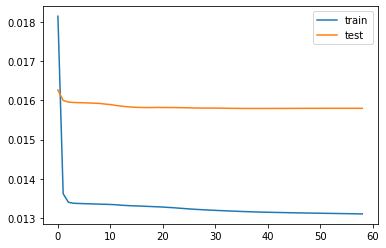

MSE Threshold T1: 0.48338813365049343
Threshold: T05:, intersections included: ['K556']
Epoch 00123: early stopping
Val_los comparison:


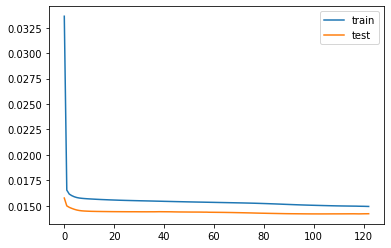

MSE Threshold T05:: 0.24621628913120855
Threshold: T04, intersections included: ['K198', 'K556', 'K557']
Epoch 00033: early stopping
Val_los comparison:


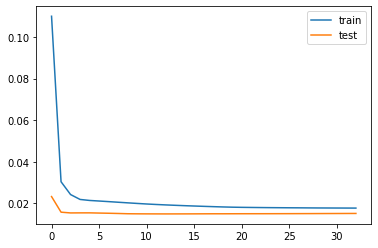

MSE Threshold T04: 0.18315756076654366
Threshold: T03, intersections included: ['K198', 'K504', 'K556', 'K557', 'K561']
Epoch 00022: early stopping
Val_los comparison:


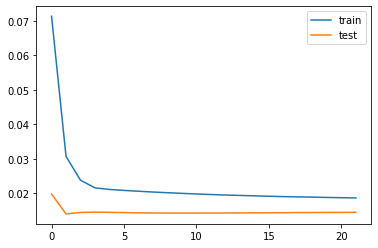

MSE Threshold T03: 0.2516705758526135
Threshold: T02, intersections included: ['K198', 'K503', 'K504', 'K556', 'K557', 'K559', 'K561']
Epoch 00067: early stopping
Val_los comparison:


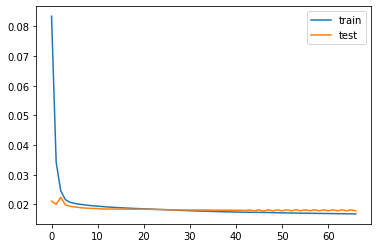

MSE Threshold T02: 0.2817630695919223
Threshold: T01, intersections included: ['K198', 'K263', 'K503', 'K504', 'K556', 'K557', 'K559', 'K561']
Epoch 00042: early stopping
Val_los comparison:


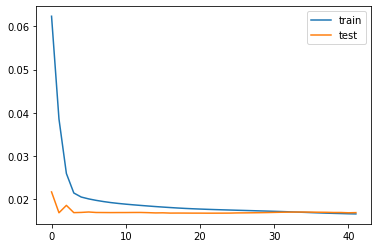

MSE Threshold T01: 0.3522553046176597
Threshold: T0, intersections included: ['K198', 'K263', 'K503', 'K504', 'K556', 'K557', 'K559', 'K561', 'K263']
Epoch 00022: early stopping
Val_los comparison:


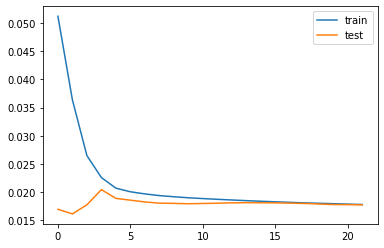

MSE Threshold T0: 0.27124110795829354


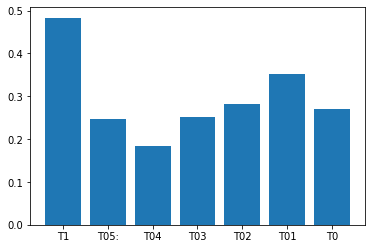

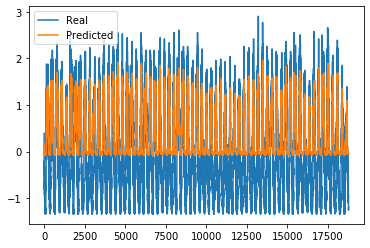

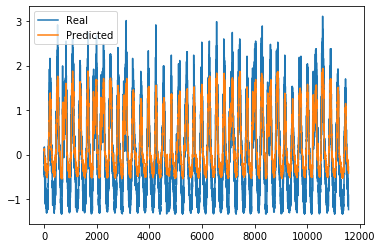

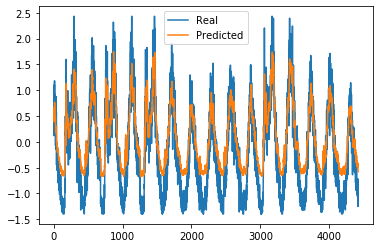

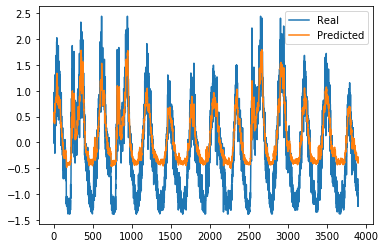

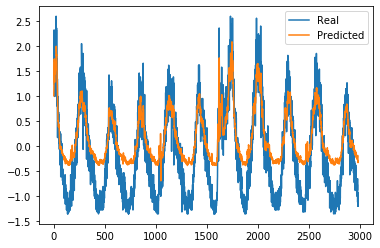

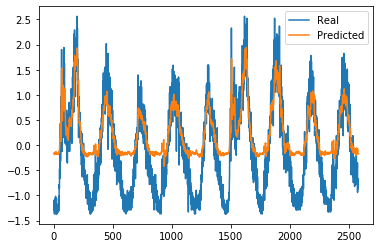

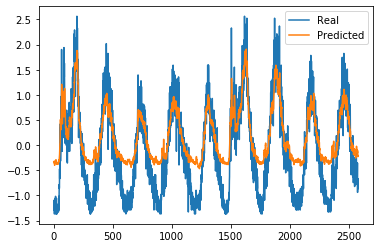

[31.201245599999993, 40.832522800000106, 5.929123899999922, 4.597015099999908, 8.444096499999887, 5.4850148000000445, 4.013400999999931]


In [17]:
folder=".//full_pickles//T1//North//"
threshold_dict={"T04":['K198', 'K556', 'K557']}
target_isct="K502"

times502, erros502, mse502 = train_models(threshold_dict)

Text(0.5, 1.0, 'K502: MSE for different Thresholds')

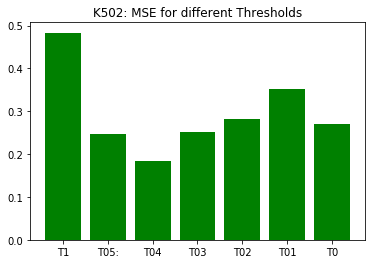

In [35]:
import seaborn as sns
plt.bar(mse502.keys(),mse502.values(), color='g')
plt.title('K502: MSE for different Thresholds')

Threshold: T1, intersections included: []
Epoch 00102: early stopping
Val_los comparison:


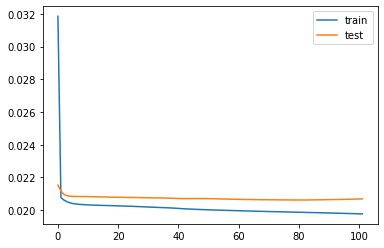

MSE Threshold T1: 0.41214221102426885
Threshold: T05, intersections included: ['K556']
Epoch 00061: early stopping
Val_los comparison:


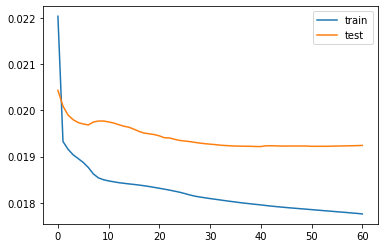

MSE Threshold T05: 0.2708729827878669
Threshold: T04, intersections included: ['K556', 'K557']
Epoch 00090: early stopping
Val_los comparison:


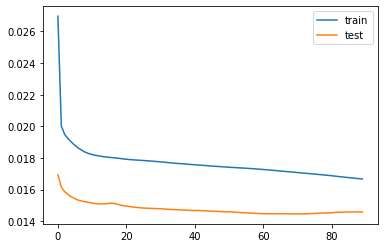

MSE Threshold T04: 0.3711199562747462
Threshold: T03, intersections included: ['K556', 'K557', 'K198', 'K561', 'K502', 'K503']
Epoch 00054: early stopping
Val_los comparison:


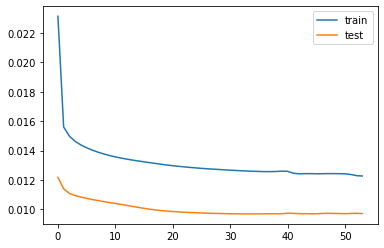

MSE Threshold T03: 0.2477100443517121
Threshold: T02, intersections included: ['K556', 'K557', 'K198', 'K561', 'K502', 'K503', 'K559']
Epoch 00060: early stopping
Val_los comparison:


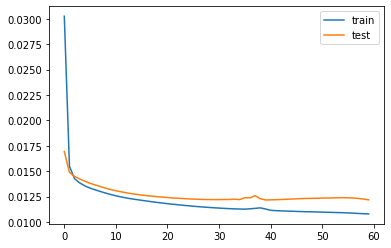

MSE Threshold T02: 0.3217152648562577
Threshold: T0, intersections included: ['K556', 'K557', 'K198', 'K561', 'K502', 'K503', 'K559', 'K263']
Epoch 00112: early stopping
Val_los comparison:


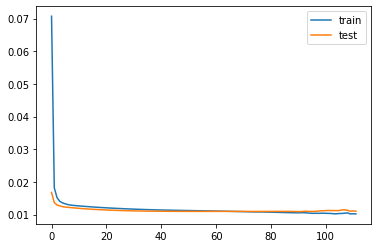

MSE Threshold T0: 0.3442158737646693


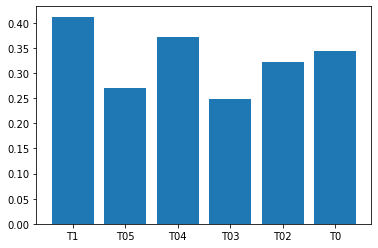

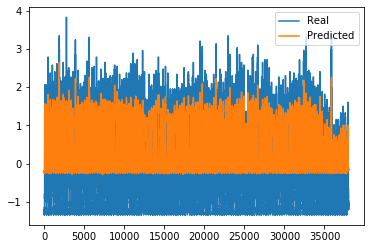

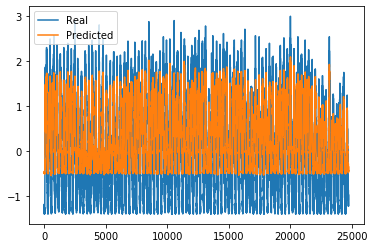

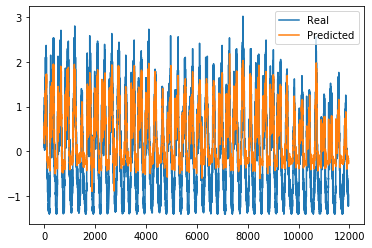

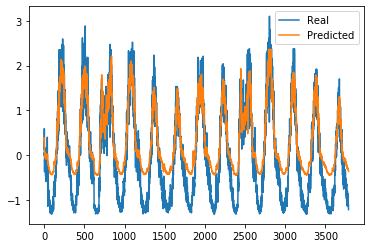

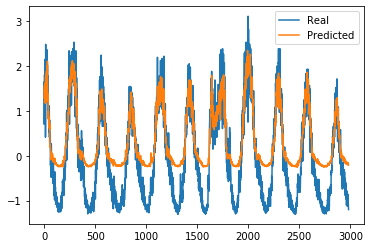

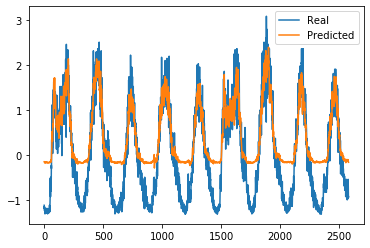

[105.68378759999996, 42.65485690000014, 31.65943070000003, 8.828577799999948, 7.9072055000001455, 12.246546800000033]


In [32]:
#to look at south trajectory:
folder=".//full_pickles//T1//South//"
threshold_dict504={"T03":['K556', 'K557', 'K198', 'K561', 'K502', 'K503']}
target_isct="K504"
times504, errors504, mse504 = train_models(threshold_dict504,target_isct)

Text(0.5, 1.0, 'Real vs Predicted values for K502 T04 model')

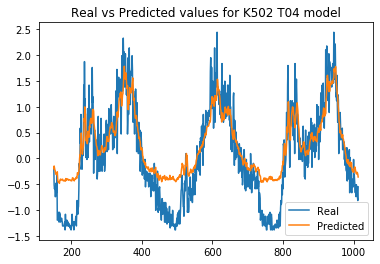

In [47]:
erros502[3][['Real','Predicted']][150:150+288*3].plot()
plt.title('Real vs Predicted values for K502 T04 model')

Text(0.5, 1.0, 'Real vs Predicted values for K504 T03 model')

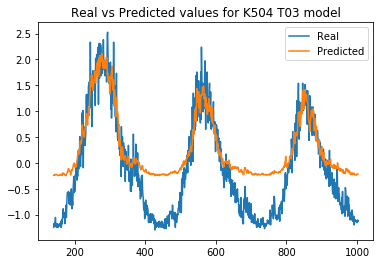

In [52]:
errors504[4][['Real','Predicted']][140:140+288*3].plot()
plt.title('Real vs Predicted values for K504 T03 model')

In [ ]:
folder=".//full_pickles//T1//North//"
threshold_dict={"T04":['K198', 'K556', 'K557']}
target_isct="K502"

times502_2, erros502_2, mse502_2, mod502_2 = train_models(threshold_dict)

In [ ]:
folder=".//full_pickles//T1//South//"
threshold_dict504={"T03":['K556', 'K557', 'K198', 'K561', 'K502', 'K503']}
target_isct="K504"
times504, errors504, mse504,mod504 = train_models(threshold_dict504,target_isct)

Text(0.5, 1.0, 'K504: MSE for different Thresholds')

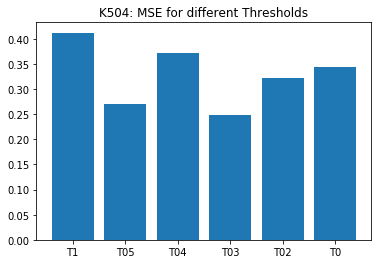

In [36]:
plt.bar(mse504.keys(),mse504.values())
plt.title('K504: MSE for different Thresholds')